Author: Chris Suberlak ([@suberlak](https://github.com/lsst-sitcom/sitcomtn-072/issues/new?body=@suberlak))

Software Versions:

* ts_wep: **v6.0.2**
* lsst_distrib: **w_2023_14**

# Introduction

The Sensitivity Matrix is a way of quantifying the relationship between measured wavefront curvature (Zernike coefficients), and the required mechanical correction (mm of hexapod motion). As described in https://tstn-016.lsst.io/ , for auxiliary telescope (auxTel) it concerns the motion of the M2 mirror hexapod in one of three directions: x,y,z. `ts_wep` quantifies the wavefront using the annular Noll Zernike coefficients terms 4-22, called 4 (defocus), 5-6 (primary astigmatism),  7-8 (primary coma), 9-10 (trefoil), 11 (primary spherical), 12-13 (secondary astigmatism), 14-15 (quadrafoil), 16-17 (secondary coma), 18-19 (secondary trefoil), 20-21 (pentafoil), as illustrated on this image: 


<figure>
<img src="zernike_noll.PNG" alt="Noll Zernikes" style="width:80%">
<figcaption style='text-align: center;'><b>Fig.1  Noll Zernike expansion</b></figcaption>
</figure>



  . For auxTel sensitivity matrix, we only use the defocus (`Z4`), and primary coma (`Z7`,`Z8`), as related to `dx`,`dy`,`dz` hexapod motion (with `dz` affecting primarily defocus term `Z4`,  `dx` the coma-x `Z7`,  and dy the coma-y `Z8`). 


$\begin{bmatrix}
\tag{1}
   dx \\
   dy \\
   dz
   \end{bmatrix}
   =
   \begin{bmatrix}
   C_{X}        & C_{YX} C_{Y} & C_{ZX} D_{Z} \\
   C_{XY} C_{X} & C_{Y}        & C_{ZY} D_{Z} \\
   C_{XZ} C_{X} & C_{YZ} C_{Y} &   D_{Z}
   \end{bmatrix}
   \times
   \begin{bmatrix}
   Z7 & Z8 & Z4
   \end{bmatrix}$

Due to tilts in the system, some of the cross-terms are non-zero (eg. $C_{ZY}$ measuring the impact of `dy` motion on `Z4` ). The original sensitivity matrix for auxTel was derived with data from 20200218, using a notebook [CWFS Sensitivity Matrix Determination](https://github.com/lsst-ts/ts_notebooks/blob/develop/procedures/CWFS_Sensitivity_Matrix_Determination.ipynb). The resulting sensitivity matrix was included in the [latiss_base_align](https://github.com/lsst-ts/ts_externalscripts/blob/a8d2a5191d2230d2875b44a881a878e4bca5cbd4/python/lsst/ts/externalscripts/auxtel/latiss_base_align.py#L120) script as 

```
        self.matrix_sensitivity = [
            [1.0 / 206.0, 0.0, 0.0],
            [0.0, -1.0 / 206.0, -(109.0 / 206.0) / 4200],
            [0.0, 0.0, 1.0 / 4200.0],
        ]
```

In this notebook we show how this matrix can be updated with the auxTel data taken during the [March 10th, 2023 run](https://confluence.lsstcorp.org/display/LSSTCOM/2023-03-10+AuxTel+Night+Log). 

# Setup

* access to USDF devl nodes
* working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) on how to install and build the AOS packages)


# Imports



In [1]:
from lsst.daf.butler import Butler
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline
from lsst_efd_client import EfdClient
import os
os.environ['NUMEXPR_MAX_THREADS'] = '8'
import subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval
from astropy.time import Time, TimeDelta
from astropy.table import Table
from scipy.optimize import curve_fit
from galsim.zernike import zernikeRotMatrix

from numexpr.utils import log as numexpr_logger
from logging import WARN
numexpr_logger.setLevel(WARN)

import pandas as pd
import warnings
# to prevent butler from displaying the username
# with INFO:botocore.credentials
warnings.filterwarnings('ignore') 

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
def line(x,b, m):
    return b + m*x 

## Data

The [observing run on 2023-03-10](https://confluence.lsstcorp.org/display/LSSTCOM/2023-03-10+AuxTel+Night+Log) included multiple tests, as described in [analyzeWepOutput](https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/notebooks/auxtel/observing_runs/20230310/analyzeWepOutput.ipynb) notebook.  . 
    In this tech note we only use the subset of [sequence numbers](https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-03-10)  pertaining to [sensitivity matrix calculation](https://jira.lsstcorp.org/browse/SITCOM-718), using as target HD66225 (observations taken first that night, using HD53897 as target, did not include the z-offsets, see [Night Log](https://confluence.lsstcorp.org/display/LSSTCOM/2023-03-10+AuxTel+Night+Log)). The sequence numbers 71-211 include the x/y, rx/ry, z, m1 pressure offsets. 
    
The raw auxTel data  for `20230310` is in `LATISS/raw/all` collection in `/repo/embargo`. The information about exposure times  and angles needed to derotate the Zernikes is obtained from the Engineering Facility Database (EFD) via the [EFD client](https://efd-client.lsst.io/). 


## Find CWFS pairs 

We find pairs of defocal exposures used for wavefront estimation by selecting on `exposure.observation_type` equal to `cwfs` and querying the `record` to find sequential poirs  that have `observation_reason` starting with `intra` and `extra`, respectively. 

In [3]:
input_collections = ['LATISS/raw/all', 'LATISS/calib/unbounded']

butler = Butler(
    "/repo/embargo",
    collections=input_collections,
    instrument='LATISS'
)


records = list(
    butler.registry.queryDimensionRecords(
        "exposure",
        where="exposure.observation_type='cwfs' and exposure.day_obs=20230310"
    )
)
records.sort(key=lambda record: (record.day_obs, record.seq_num))

# Loop through and make pairs where 1st exposure is intra and second exposure is extra and have same group_id
# Save record information for each pair and sequence numbers for easy location later.
pairs = []
seq_nums = []
for record0, record1 in zip(records[:-1], records[1:]):
    if (
        record0.observation_reason.startswith('intra') and
        record1.observation_reason.startswith('extra') and
        record0.group_id == record1.group_id and
        not record0.physical_filter.startswith("empty")
    ):
        pairs.append((record0, record1))
        seq_nums.append(record0.seq_num)
        
# this only stores the first seqNum in each pair 
seq_nums = np.array(seq_nums)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/s/scichris/.lsst/aws-credentials.ini


## Run AOS pipeline

For completeness, the cell below runs the complete pipeline  that does the instrument signature removal with `isr` task , donut detection with `generateDonutDirectDetectTask`, cutting out of donut stamps with `cutOutDonutsScienceSensorTask`, wavefront estimation with `calcZernikesTask`, is contained in the `latissWepPipeline.yaml` file (it is similar to [latissWepPipeline](https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/notebooks/auxtel/observing_runs/20230310/latissWepPipeline.yaml) used earlier, except for the image transpose). It can also be run via bps, by running the `run_bps_wep_submit.py` submission script (included in the github repository of this technote).  The code below assumes that the `$USER` obtained from `os.getlogin()` is the same as the `u/$USER` collection to which one has write access.

This runs the full pipeline, i.e. from the raws, does limited ISR (no CR repair). 

In [4]:
repo_dir = '/sdf/data/rubin/repo/embargo/'
user = os.getlogin()
output_collection = f'u/{user}/latiss_230310_run/wep_full'


butler = Butler(repo_dir)
registry = butler.registry
collections_list = list(registry.queryCollections())

# skip if collection already exists
if output_collection in collections_list:
    print(f'{output_collection} already exists, skipping')
    
else: 
    butlerRW = SimplePipelineExecutor.prep_butler(repo_dir, 
                                                  inputs=input_collections, 
                                                  output=output_collection)
    path_to_pipeline_yaml = os.path.join(os.getcwd(), 'latissWepPipeline.yaml' ) 

    # Load pipeline from file
    pipeline = Pipeline.from_uri(path_to_pipeline_yaml)

    # run the pipeline for each CWFS pair... 
    for record0, record1 in pairs:
        day_obs = record0.day_obs
        first = record0.seq_num
        second = record1.seq_num

        data_query = f"exposure in ({first}..{second})"
        executor = SimplePipelineExecutor.from_pipeline(pipeline, where=data_query, butler=butlerRW)
        quanta = executor.run(True)

u/scichris/latiss_230310_run/wep_full already exists, skipping


# Obtain the derotation angle from the EFD

In [5]:
efd_client = EfdClient('usdf_efd')

spans = []

day_obs = '20230310'
butler = Butler('/sdf/data/rubin/repo/embargo/')
datasetRefs = butler.registry.queryDatasets('raw',collections='LATISS/raw/all',
                              where=f"instrument='LATISS' AND exposure.day_obs = {day_obs}").expanded()

records = []
for i, ref in enumerate(datasetRefs):
    record = ref.dataId.records["exposure"]
    exp = record.dataId['exposure']
    records.append(record)
    spans.append(record.timespan)
    
t1= min(spans)
t2 = max(spans)

end_readout = await efd_client.select_time_series("lsst.sal.ATCamera.logevent_endReadout", 
                                          '*', t1.begin.utc, t2.end.utc)


Obtain the time of the end of readout of intra image and extra image in each pair: 

In [6]:
m = (end_readout['imageNumber'] > 69) * (end_readout['imageNumber'] < 212)
subset = end_readout[m]
intra_times = []
extra_times = []

intra_images = []
extra_images = []

intra_programs = []
extra_programs = []

intra_exptimes = []
extra_exptimes = []


for i in range(len(subset)):
    num = subset['imageNumber'][i]
    values = subset['additionalValues'][i]
    imageName = subset['imageName'][i]
    expTime = subset['requestedExposureTime'][i]
    
    time = subset.index[i] # time of end readout 
    timestamp = ''.join(values.split(':')[1:-6])
    program = values.split(':')[-2]
    
    if program.startswith('INTRA_AOS_SM_offset'):
        intra_times.append(time)
        intra_images.append(imageName)
        intra_programs.append(program)
        intra_exptimes.append(expTime)
        
    elif program.startswith('EXTRA_AOS_SM_offset'):
        extra_times.append(time)
        extra_images.append(imageName)
        extra_programs.append(program)
        extra_exptimes.append(expTime)
        
    if program.startswith('FINAL'):
        zero_time = time
        zero_image = imageName
        zero_program = program

Find the elevation angle, azimuth angle, rotator angle by querying the EFD for this information contained between the beginning of the intra-focal exposure, and the end of the extra-focal exposure. These angles were changing continuously during each intra / extra exposure, and we consider the mean for the derotation angle, since the wavefront is estimated based on the combined information between intra-focal and extra-focal exposures. 

In [7]:
t1 = Time(zero_time) - TimeDelta(25, format='sec')
t2 = Time(zero_time)
correction_0 = await efd_client.select_time_series("lsst.sal.ATAOS.logevent_correctionOffsets",
                                                 ["x","y","z","u","v","w"], t1,t2)   

azimuth_list = []
elevation_list = []
rot_pos_list = []
camrot_list = []

for i in range(len(intra_times)):
    
   # 5 sec before the beginning of exposure 
   # all defocal exposures are 20 sec
    t1 = Time(intra_times[i]) - TimeDelta(intra_exptimes[i]-5, format='sec') 
    
    # this is 2 sec before the end of the extra-focal exposure 
    t2 = Time(extra_times[i]) - TimeDelta(2., format='sec')
    
 
    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], 
                                               t1, t2)
    
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth2CalculatedAngle99"], t1, t2)
    
    camera = await efd_client.select_time_series("lsst.sal.MTRotator.rotation", 
                                                 ["actualPosition"], t1,t2 )
    
    azimuth_list.append(np.mean(azel['azimuthCalculatedAngle99']))
    elevation_list.append(np.mean(azel['elevationCalculatedAngle99']))
    rot_pos_list.append(np.mean(rotator['nasmyth2CalculatedAngle99']))
    camrot_list.append(np.mean(camera['actualPosition']))

# store the results as astropy table 
d = Table(data=[intra_images, extra_images, rot_pos_list, elevation_list, azimuth_list, camrot_list],
         names=['intra','extra', 'rot', 'el','az', 'camrot'])
d['angle'] = d['rot'] - d['el']

Plot the example of how the rotator angle and elevation angle change continuously during the intra-focal and subsequent extra-focal exposure:

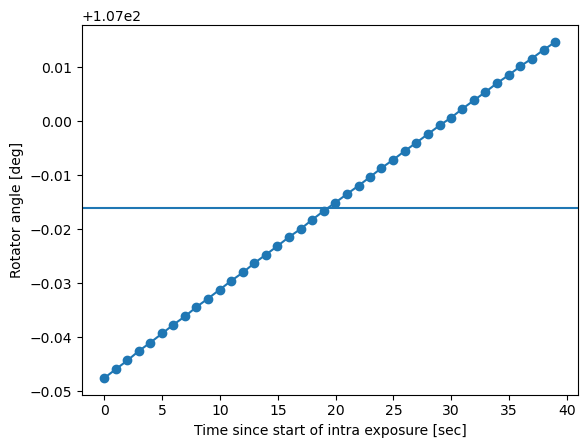

In [8]:
# print in seconds 
dt = rotator['nasmyth2CalculatedAngle99'].index - rotator['nasmyth2CalculatedAngle99'].index[0]
dt_sec = np.array(dt.values.astype(float)) / 1e9
rot = np.mean(rotator['nasmyth2CalculatedAngle99'])
plt.plot(dt_sec, rotator['nasmyth2CalculatedAngle99'].values, marker='o')
plt.xlabel('Time since start of intra exposure [sec]')
plt.ylabel('Rotator angle [deg]')
plt.axhline(rot)

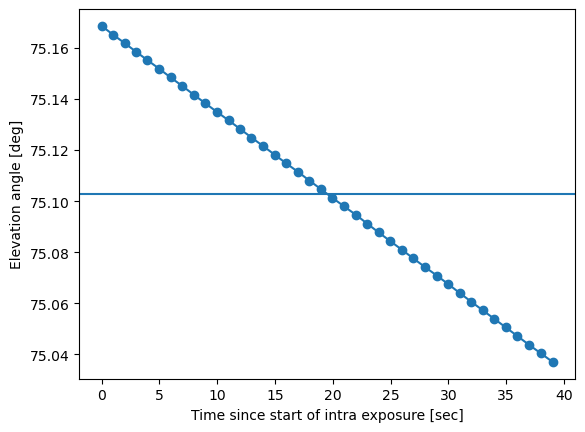

In [9]:
dt = azel['elevationCalculatedAngle99'].index - azel['elevationCalculatedAngle99'].index[0]
dt_sec = np.array(dt.values.astype(float)) / 1e9
plt.plot(dt_sec, azel['elevationCalculatedAngle99'].values, marker='o')
plt.xlabel('Time since start of intra exposure [sec]')
plt.ylabel('Elevation angle [deg]')
el = np.mean(azel['elevationCalculatedAngle99'])
plt.axhline(el)

# Inspect the results

The wavefront was measured with rotation  different than 0, and needs to be derotated to the boresight frame.

In general, Zernike terms are either not affected by rotation (eg. defocus term Z4), or they rotate in pairs  (e.g., Z7 & Z8).  For the pairs, the rotation matrix is 

$\begin{bmatrix}\tag{2}
\cos(m*a) & -\sin(m*a) \\
\sin(m*a) & \cos(m*a)
\end{bmatrix}
$

where $a$ is the angle in the coordinate system rotation and $m$ is the azimuthal order of the particular Zernike pair.  For coma, $m=1$ so that the rotation matrix has $sin(a)$ and $cos(a)$. For astigmatism, $m=2$ so the matrix contains $sin(2a)$ and $cos(2a)$. Given the maximum number of Zernike terms to rotate, the GalSim function `zernikeRotMatrix` calculates the necessary rotation matrix.

Note: the original `latiss_base_align` code derotates Zernikes using this [rotation matrix](https://github.com/lsst-ts/ts_externalscripts/blob/a8d2a5191d2230d2875b44a881a878e4bca5cbd4/python/lsst/ts/externalscripts/auxtel/latiss_base_align.py#L128):

$\tag{3}
R_{784} = 
\begin{bmatrix}
   \cos{\theta}   & -\sin{\theta} & 0 \\    
   \sin{\theta} & \cos{\theta} & 0 \\ 
   0 & 0 & 1  
\end{bmatrix}
$
   
   where $\theta = rot - el$. But Galsim `zernikeRotMatrix` rotates in the opposite direction. This can be shown with the following - we load an example set of Zernikes resulting from `ts_wep` fit. We consider only  a subset of $[Z7,Z8,Z4]$. We rotate it first using the $R_{784}(\theta)$ above. Then we rotate with Galsim by $-\theta$, and show that the resulting rotated Zernikes are the same. 

In [10]:
# the rotation matrix used in latiss_base_align
matrix_rotation = lambda angle: np.array(
        [
            [np.cos(np.radians(angle)), -np.sin(np.radians(angle)), 0.0],
            [np.sin(np.radians(angle)), np.cos(np.radians(angle)), 0.0],
            [0.0, 0.0, 1.0],
        ]
    )

# load one set of Zernikes 
seq_num=71
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)
zk4_22 =  butler.get(
            "zernikeEstimateAvg", 
            dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
        )


In [11]:
# zernikes from ts_wep  is 4:22 ... 
angle = 90 

# that is [comaX, comaY, defocus ]
zk784 = [zk4_22[7-4],zk4_22[8-4],zk4_22[4-4]]

# rotate by angle 
zk784_rot = np.matmul(zk784 , matrix_rotation(angle))
     
zk4_8 = zk4_22[ :9-4]
zk1_8 = np.pad(zk4_8, [4,0]) # pad by 4 so it starts at 0, and array[i] corresponds to zk[i]

# rotate by -angle 
zk1_8_rot_galsim = np.matmul(zk1_8, zernikeRotMatrix(8, -np.deg2rad(angle)))

zk784_rot_galsim = zk1_8_rot_galsim[[7,8,4]]

In [12]:
zk784_rot_galsim

array([-0.1319935 ,  0.32600393, -0.07967852])

In [13]:
zk784_rot

array([-0.1319935 ,  0.32600393, -0.07967852])

Thus the two sets of rotated Zernikes are the same if we use for galsim the `-angle` used in `latiss_base_align` `matrix_rotation`

[The Noll Zernike polynomials](https://telescope-optics.net/zernike_aberrations.htm) include x,y components of various optical aberrations ("moments" of expansion, eg. astigmatism, coma, trefoil). The total moment consists of x,y components added in quadrature, eg. total astigmatism $ Z{\mathrm{ast}}^{2}= Z_{5}^{2},Z_{6}^{2}$, total coma $Z_{\mathrm{coma}}^{2} = Z_{7}^{2},Z_{8}^{2}$. 

Since the total moment is invariant under rotation, we plot it first as a sanity check to confirm that rotation only shifted power between x,y components. The moments plotted include:




| Optical Aberration |  x,y components |
| :--: |  :--: | 
| Primary Astigmatism | Z5, Z6 |
| Primary Coma | Z7, Z8 |
| Primary Trefoil | Z9, Z10 |
| Secondary Astigmatism | Z12, Z13 |
| Secondary Quadrafoil | Z14, Z15 | 
| Secondary Coma | Z16, Z17 |
| Secondary Trefoil | Z18, Z19 | 
| Pentafoil | Z20, Z21 | 

 

In [14]:
%matplotlib inline


#d = Table.read('20230310_EFD_angle_data.txt', format='ascii')
#d['angle'] = d['rot'] - d['el']


def plot_derot_total(axis = 'x'):
    if axis == 'x':
        dxs = np.linspace(-2, 2, 10)  
        intra_seq_nums = np.arange(71, 90, 2)
    
    elif axis == 'y':
        dxs = np.linspace(-2, 2, 10) # this is dy 
        intra_seq_nums = np.arange(91, 110, 2)
        
    elif axis == 'z':  
        dxs = np.linspace(-0.1, 0.1, 10) # this is dz 
        intra_seq_nums = np.arange(172, 191, 2)
        
    zernikes = []
    for seq_num in intra_seq_nums:
        zernikes.append(
            butler.get(
                "zernikeEstimateAvg", 
                dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
            )
        )
    zernikes = np.array(zernikes)  # this is unrotated 4:22 

    # pad with 4 zeros so that array[N]  corresponds to ZkN
    zk1_22_list = []
    for zk4_22 in zernikes:
        zk1_22 = np.pad(zk4_22,[4,0])
        zk1_22_list.append(zk1_22)
    zk1_22_arr = np.array(zk1_22_list)


    zk1_22_rot_list = []
    for pair in range(len(intra_seq_nums)):

        zk1_22_unrot = zk1_22_arr[pair]

        seq_num = intra_seq_nums[pair]
        intra_name = 'AT_O_20230310_'+   str(seq_num).zfill(6)

        # derotate by applying matrix multiplication
        # angle = rot - el 
        angle =  d[d['intra'] == intra_name]['angle'].value[0]

        zk1_22rot = np.matmul(zk1_22_unrot, zernikeRotMatrix(22, -np.deg2rad(angle)))
        zk1_22_rot_list.append(zk1_22rot)

    zk1_22_rot_arr = np.array(zk1_22_rot_list)

    titles = {5:'astigmatism', 7:'coma', 9:'trefoil', 
                  12:'2nd astigmatism',14:'quadrafoil',16:'2nd coma',
                  18:'2nd trefoil',20:'pentafoil'}

    # rename rotated 4:22 to use the same plotting code 
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8,12))
    axes = axes.ravel()
    xdata = dxs
   
    i = 0 
    for j in titles.keys():
        
        # plot the rotated Zks 
        zk_x = zk1_22_rot_arr[:,j]  # eg. zk5
        zk_y = zk1_22_rot_arr[:,j+1]  # eg, zk6 
        ydata = np.sqrt(zk_x**2. + zk_y**2.)
        axes[i].scatter(xdata, ydata, marker='d',s=95, label='original')
        
        # plot the unrotated Zks 
        zk_x = zk1_22_arr[:,j]
        zk_y = zk1_22_arr[:,j+1]
        ydata = np.sqrt(zk_x**2. + zk_y**2.)
        axes[i].scatter(xdata, ydata, marker='s', label='rotated')
        
        axes[i].set_title(f"Z{j,j+1}: {titles[j]}")

        i += 1

    for ax in axes:
        ax.set_ylim(-0.02, 0.36)
        ax.axhline(0, c='k')
    fig.text(0.44,0, f"M2 d{axis} [mm]", fontsize=14)
    fig.text(-0.02
             ,0.4,"WFE [µm]", rotation='vertical',fontsize=14 )
    plt.tight_layout()
    plt.show()


In [15]:
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

Note: in the image below the y-axis is set to the same range to allow easier comparison between total amount of optical distortion in different Zernike modes. 

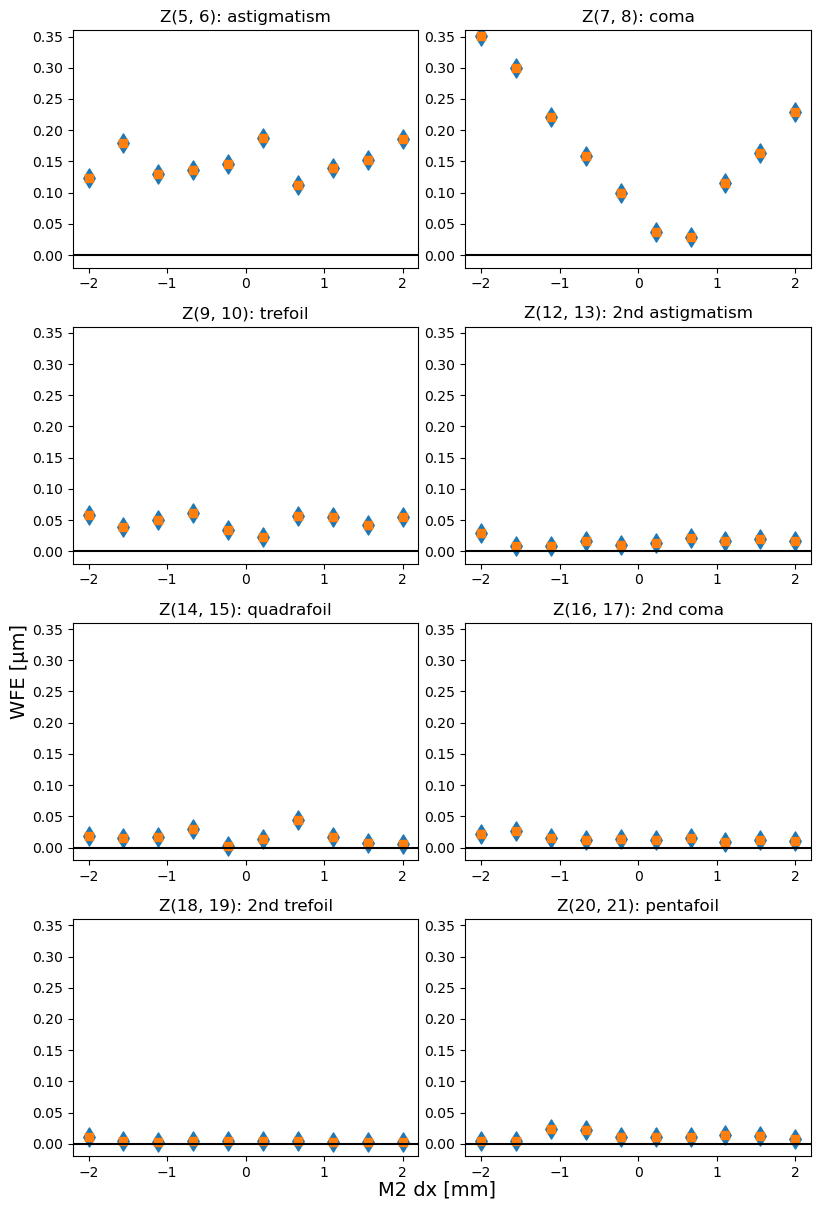

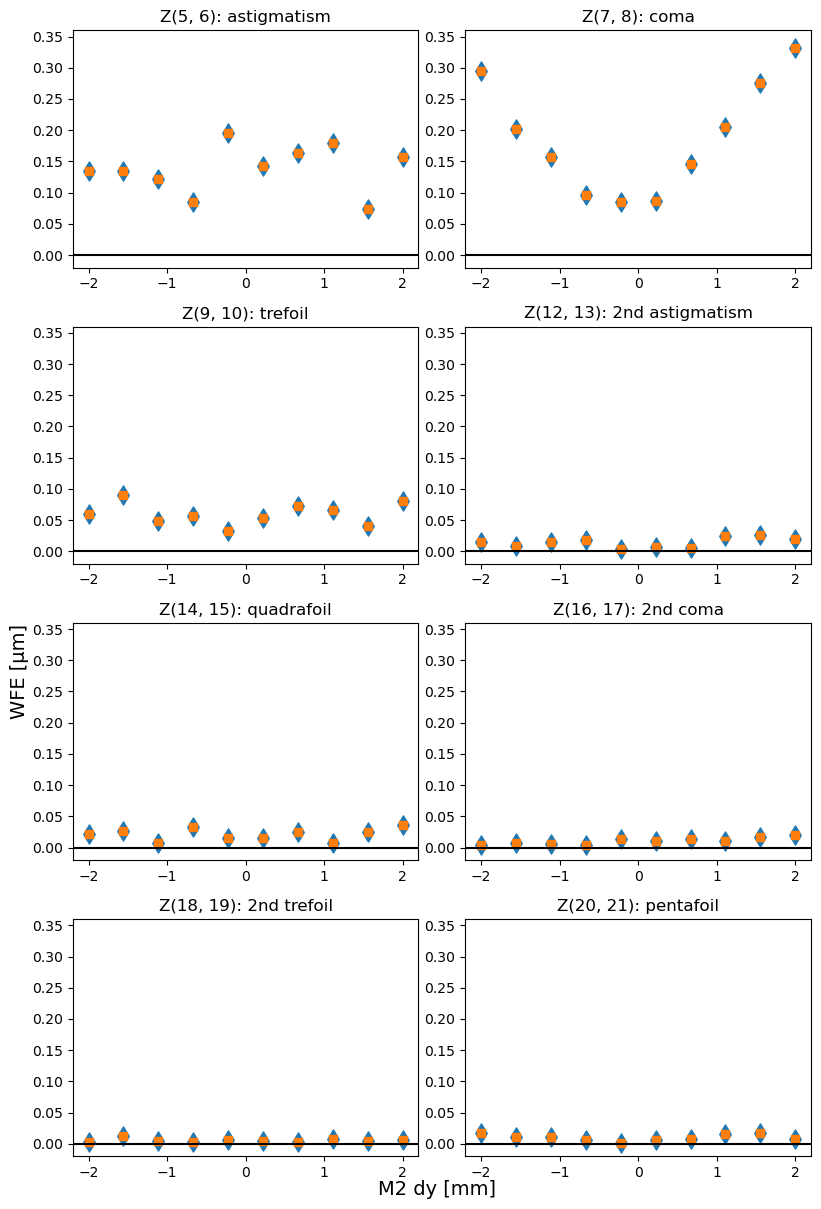

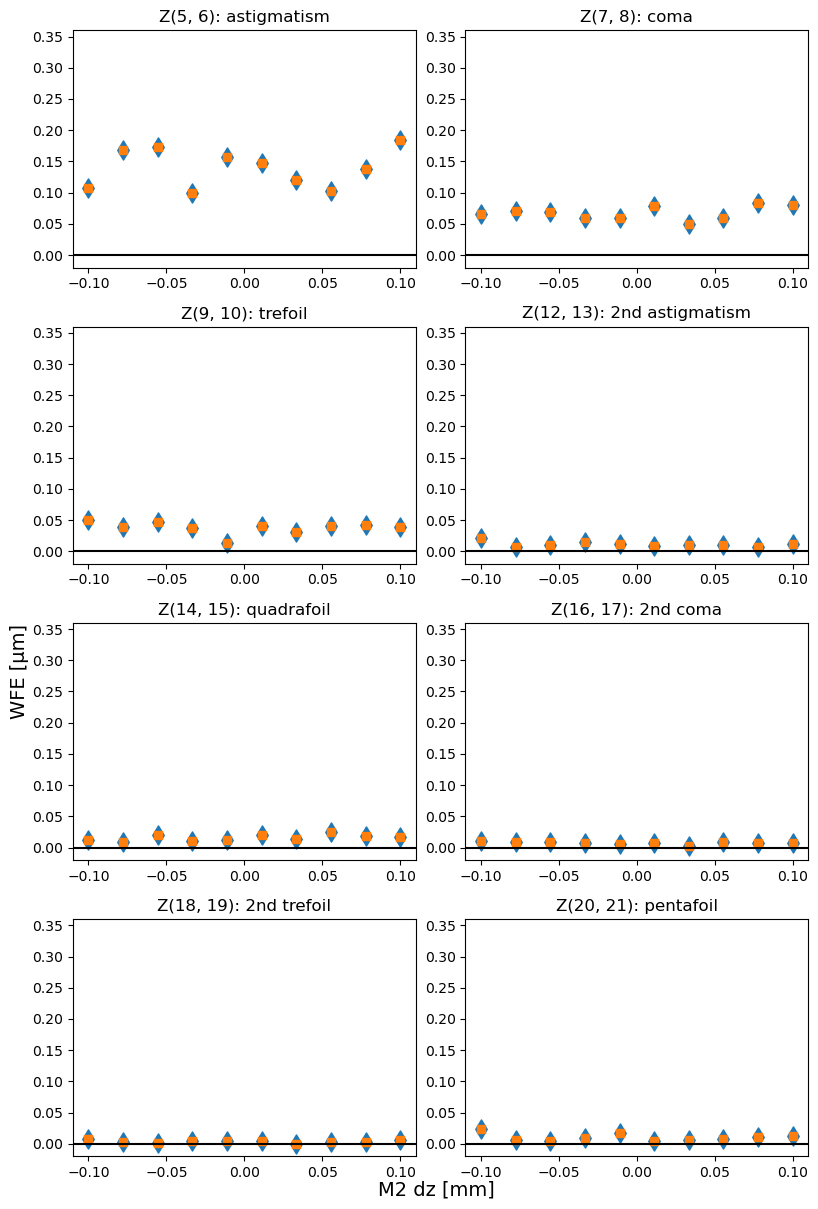

In [16]:
for axis in 'xyz':
    plot_derot_total(axis = axis)

Blue diamonds are original (rotated), and  orange squares are derotated Zernike values. They are identical because the total coma / astigmatism / trefoil is invariant under rotation. 

# Plot only a subset of Zernikes relevant to sensitivity matrix calculation (defocus, comaX, comaY)

In [17]:

def plot_sens_rot_zk478(axis = 'x', verbose=True, add_angle=0, mult_angle = 1, swap_xy_coma = True,
                       pre = '-'):
    if axis == 'x':
        dxs = np.linspace(-2, 2, 10)  
        intra_seq_nums = np.arange(71, 90, 2)  
    elif axis == 'y':
        dxs = np.linspace(-2, 2, 10) # this is dy 
        intra_seq_nums = np.arange(91, 110, 2)
    elif axis == 'z':  
        dxs = np.linspace(-0.1, 0.1, 10) # this is dz 
        intra_seq_nums = np.arange(172, 191, 2)
    
    # read in the appropriate Zernike coefficients 
    zernikes = []
    for seq_num in intra_seq_nums:
        zernikes.append(
            butler.get(
                "zernikeEstimateAvg", 
                dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
            )
        )
    zernikes = np.array(zernikes)

    # first, pad with 4 zeros so that array[N]  corresponds to ZkN
    zk1_22_list = []
    for zk4_22 in zernikes:
        zk1_22 = np.pad(zk4_22,[4,0])
        zk1_22_list.append(zk1_22)
    zk1_22_arr = np.array(zk1_22_list)

    # now derotate using the  EFD angle = el-rot 
    zk1_22_rot_list = []
    for pair in range(len(intra_seq_nums)):

        zk1_22_unrot = zk1_22_arr[pair]
        if  swap_xy_coma : 
            # swap x,y coma ... 
            x_coma = zk1_22_unrot[7]
            y_coma = zk1_22_unrot[8]
            zk1_22_unrot[7] = y_coma
            zk1_22_unrot[8] = x_coma
        seq_num = intra_seq_nums[pair]
        intra_name = 'AT_O_20230310_'+   str(seq_num).zfill(6)

        # derotate using angle = rot-el 
        #                      = Nasmyth2CalculatedAngle- elevationCalculatedAngkle
        angle =  d[d['intra'] == intra_name]['angle'].value[0]

        # in the latiss_base_align, the rotation is by 
        # angle + camera_rotation_angle, where
        # camera_rotation_angle is orientation of the 
        # detector relative to the rotator, 
        # assumed to be within a degree or two 
        zk1_22rot = np.matmul(zk1_22_unrot, zernikeRotMatrix(22, 
                              np.deg2rad(add_angle+mult_angle*angle)))
        zk1_22_rot_list.append(zk1_22rot)

    zk1_22_rot_arr = np.array(zk1_22_rot_list)
    
    # plot the derotated and the rotated Zks 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    axes = axes.ravel()
    xdata = dxs
    
    # rotated
    if verbose:
        print('\n Rotated ')
    col=0
    
    slopes = []
    for j in [7,8,4]: # range(4, 23): 
        ydata = 1000*zk1_22_rot_arr[:,j] # use nm 
        axes[col].scatter(dxs, ydata,)
        
        # fit straight line 
        x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
        popt,pcov = curve_fit(line, xdata, ydata)
        if verbose:
            print(f'Z{j} as func of dx displacement fit intercept and slope ',popt)
        axes[col].plot(x,line(x, *popt),
         label=f'fit slope {np.round(popt[1],1)}nm / mm', alpha=0.8)
        axes[col].set_ylabel(f'Z{j} [nm]')
        col += 1 
        if verbose: print('1/slope=', 1/popt[1])
        
        slopes.append(popt[1])
        
    # The original senM we're comparing to: 
    #     self.matrix_sensitivity = [
    #             [1.0 / 206.0, 0.0, 0.0],
    #             [0.0, -1.0 / 206.0, -(109.0 / 206.0) / 4200],
    #             [0.0, 0.0, 1.0 / 4200.0],
    #         ]
    xleg = 0
    yleg = 1.2 
    loc_string = 'lower left'
    
    mult = int(pre+'1')
    # we're plotting   zk7, zk8  ,zk4 
    if axis == 'x':
        # dx slopes 
        # Z7 as a function of dx : Cx 
        ax_idx = 0 # zk7
        popt = [+7.20791437, mult*206]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string, bbox_to_anchor=(xleg, yleg ))
        
    
    elif axis == 'y':
        # dy slopes 
        # z4: defocus as function of dy : Czy  
        ax_idx = 2
        
        popt = [+7.20791437, mult*(-109)]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string,bbox_to_anchor=(xleg, yleg ))

        # Z8 (comaY) as function of dy : Cy 
        ax_idx = 1
        popt = [+7.20791437, mult*(-206)]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string, bbox_to_anchor=(xleg, yleg ))
        
    elif axis == 'z':
        # dz slopes
        # Z4: defocus as function of dz : Dz
        ax_idx = 2
        popt = [+7.20791437, mult*4200]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=[0,1], bbox_to_anchor=(xleg, yleg ))


    for ax in axes:#[:-1]:
        ax.set_ylim(-300, 300)
        ax.axhline(0, c='k')
        #ax.set_ylabel()
        ax.set_xlabel(f"M2 d{axis} [mm]")
        
    fig.suptitle(f'Rotation by  Galsim({add_angle} + {mult_angle}*angle), slope= {pre}senM term', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return slopes 

We can run `ts_wep` pipeline with a boolean config `calcZernikesConfig.transposeImages`, which transposes the postISR images before running the Zernike estimation. This is the default with `phoSim` simulated images. We expect comaX to depend on dx displacement, and comaY  on dy.  It turns out that without applying the transpose, we get the opposite behavior  (i.e. comaX depending on dy,  comaY on dx). In the plots below, `senM` stands for the slope value from the `matrix_sensitivity` above, eg. $C_{x} = 1/206.0$ corresponds to a slope of $206$ nm/mm.


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [  60.87750239 -145.20305461]
1/slope= -0.006886907460044104
Z8 as func of dx displacement fit intercept and slope  [29.55216431 -7.0379821 ]
1/slope= -0.1420861811180882
Z4 as func of dx displacement fit intercept and slope  [-42.70664384  -5.25989789]
1/slope= -0.19011775909558462


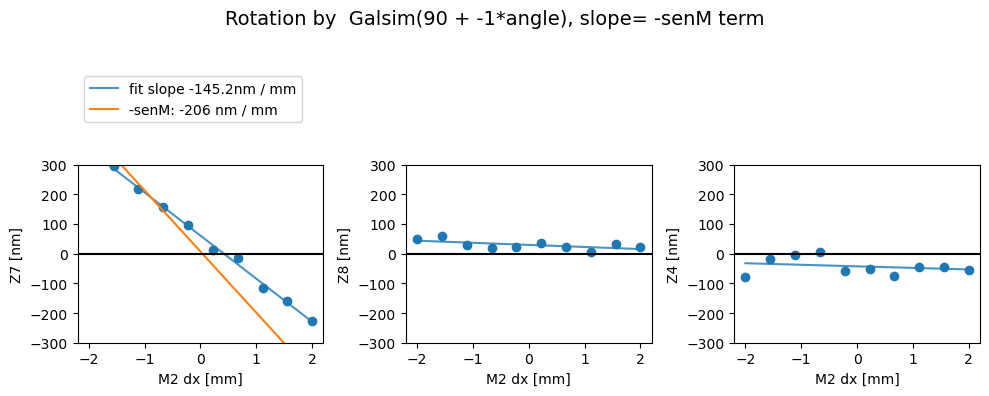


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [54.77759387  1.84962481]
1/slope= 0.5406501858986662
Z8 as func of dx displacement fit intercept and slope  [ 24.6973816  153.65157085]
1/slope= 0.006508231542932624
Z4 as func of dx displacement fit intercept and slope  [-57.22614764  18.17853625]
1/slope= 0.0550099296449157


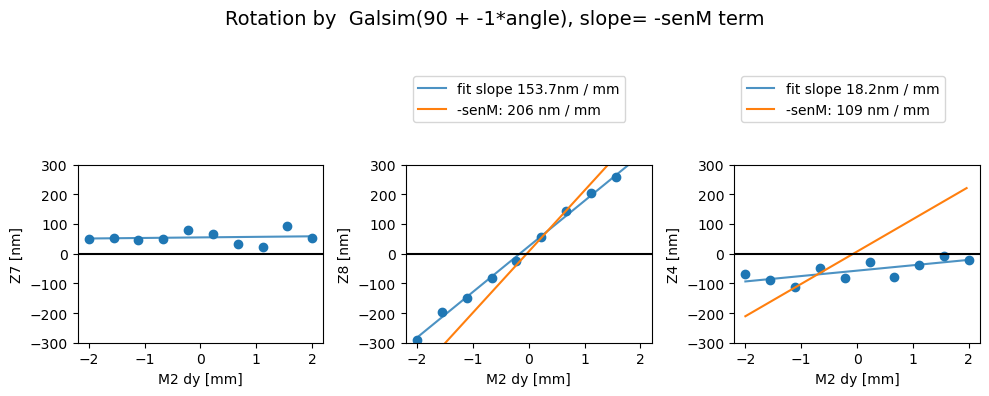


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [65.85094081 27.9882209 ]
1/slope= 0.03572931639687421
Z8 as func of dx displacement fit intercept and slope  [-3.22341484 45.20044489]
1/slope= 0.022123676047898166
Z4 as func of dx displacement fit intercept and slope  [  -47.69477378 -3894.91079696]
1/slope= -0.00025674528946318607


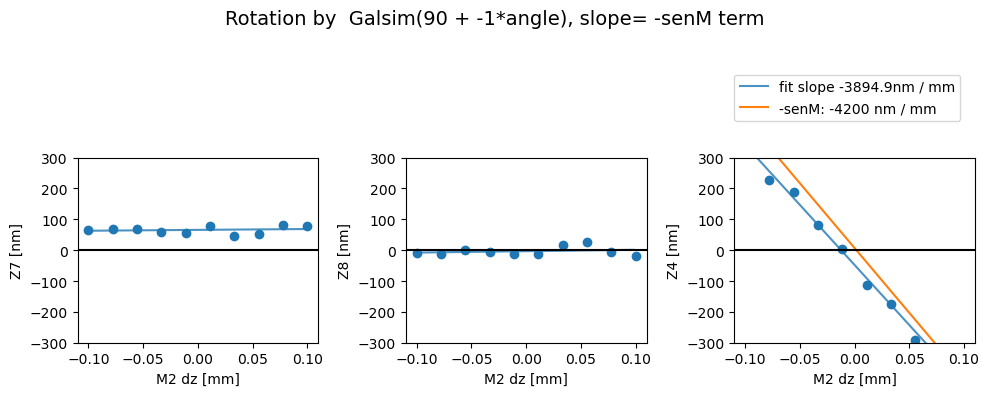

In [18]:
output_collection = 'u/scichris/latiss_230310_run/wep_no_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

for axis in 'xyz':
    slopes = plot_sens_rot_zk478(axis=axis, add_angle=90, mult_angle = -1)

With the transpose, we get the correct behavior - i.e. there's a comaX dependence on `dx`, and comaY dependence on `dy`:


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [  60.87750239 -145.2030546 ]
1/slope= -0.006886907460396176
Z8 as func of dx displacement fit intercept and slope  [29.55216427 -7.03798224]
1/slope= -0.14208617835920004
Z4 as func of dx displacement fit intercept and slope  [-42.70664388  -5.25989759]
1/slope= -0.19011776980762635


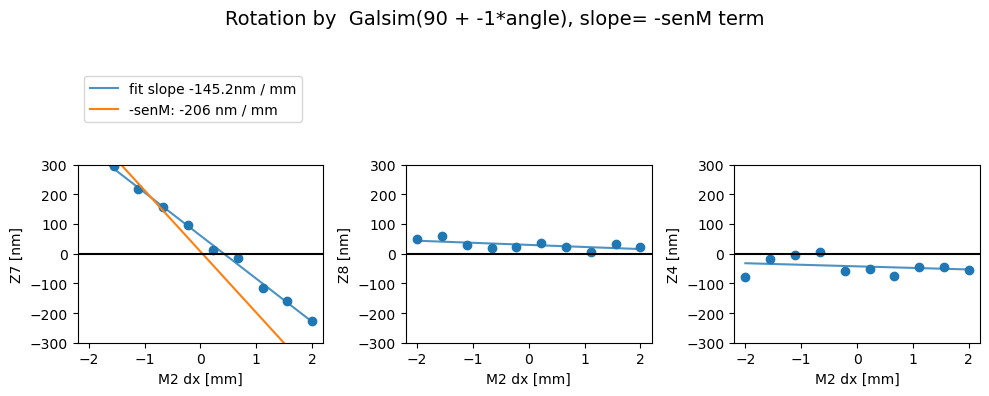


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [54.77759383  1.84962474]
1/slope= 0.5406502076992792
Z8 as func of dx displacement fit intercept and slope  [ 24.69738157 153.65157087]
1/slope= 0.0065082315418858745
Z4 as func of dx displacement fit intercept and slope  [-57.22614764  18.17853627]
1/slope= 0.05500992957311213


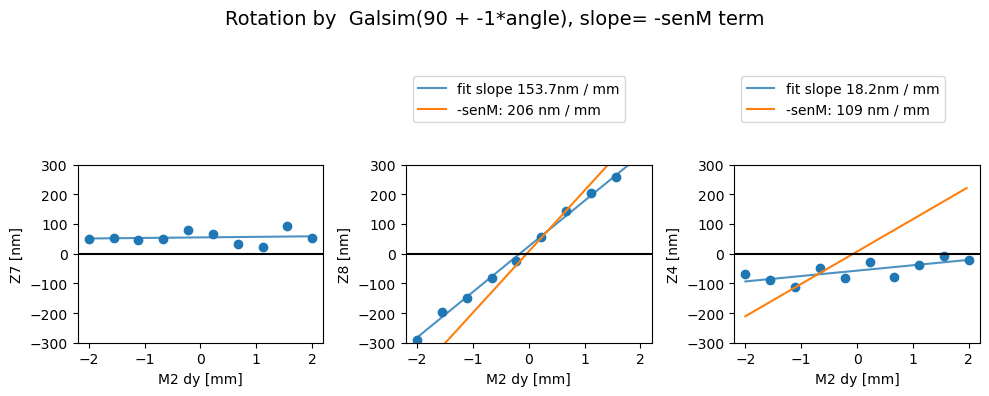


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [65.85094081 27.98822459]
1/slope= 0.03572931168827265
Z8 as func of dx displacement fit intercept and slope  [-3.22341477 45.20044742]
1/slope= 0.02212367480814095
Z4 as func of dx displacement fit intercept and slope  [  -47.69477378 -3894.91079784]
1/slope= -0.00025674528940569554


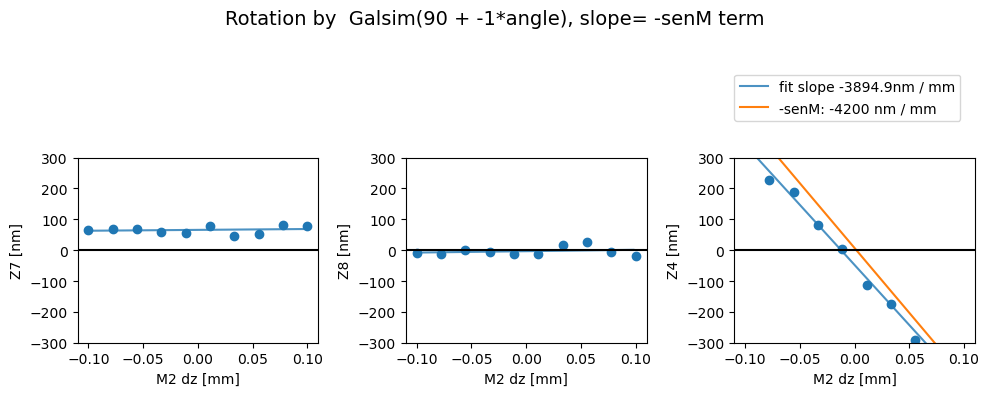

In [19]:
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

slope_dic = {}
for axis in 'xyz':
    slopes = plot_sens_rot_zk478(axis=axis, add_angle=90, mult_angle = -1, swap_xy_coma=False,
                                pre='-')
    slope_dic[axis] = slopes

In [20]:
slope_dic

{'x': [-145.20305460042786, -7.037982241115364, -5.259897594064277],
 'y': [1.8496247402835009, 153.65157087054595, 18.17853627081868],
 'z': [27.988224590630104, 45.20044742440462, -3894.910797836887]}

We have measured directly the slopes that form the following Jacobian: 
    
```
[Z7]   [ dZ7/dx  dZ7/dy  dZ7/dz ]   [dx]
[Z8] = [ dZ8/dx  dZ8/dy  dZ8/dz ] * [dy]  = J * X
[Z4]   [ dZ4/dx  dZ4/dy  dZ4/dz ]   [dz]
```

In [21]:
J = np.array([slope_dic['x'], slope_dic['y'], slope_dic['z']]).T
np.set_printoptions(formatter={'float_kind':'{:.8f}'.format})
J

array([[-145.20305460, 1.84962474, 27.98822459],
       [-7.03798224, 153.65157087, 45.20044742],
       [-5.25989759, 18.17853627, -3894.91079784]])

The sensitivity matrix is the inverse of that Jacobian:

In [22]:
M = -np.linalg.inv(J)
np.set_printoptions(formatter={'float_kind':'{:.4f}'.format})
M*1000

array([[6.8894, -0.0887, 0.0485],
       [0.3179, -6.5034, -0.0732],
       [-0.0078, -0.0302, 0.2563]])

Compare that to the original matrix:

In [23]:
M0 = np.array([[1.0 / 206.0,      0.0,                       0.0],
[ 0.0,          -1.0 / 206.0,     -(109.0 / 206.0) / 4200],
[ 0.0,             0.0,                      1.0 / 4200.0]])
M0*1000

array([[4.8544, 0.0000, 0.0000],
       [0.0000, -4.8544, -0.1260],
       [0.0000, 0.0000, 0.2381]])

Thus we have that the new sensitivity matrix would be : 



In [24]:
np.set_printoptions(formatter={'float_kind':'{:.8f}'.format})
M

array([[0.00688945, -0.00008867, 0.00004848],
       [0.00031787, -0.00650340, -0.00007319],
       [-0.00000782, -0.00003023, 0.00025634]])

# Plot all derotated Zernikes as a function of hexapod motion 

For completeness, we also plot all other measured Zernikes (besides Z7,Z8,Z4 considered for sensitivity matrix) as a function of hexapod motion.


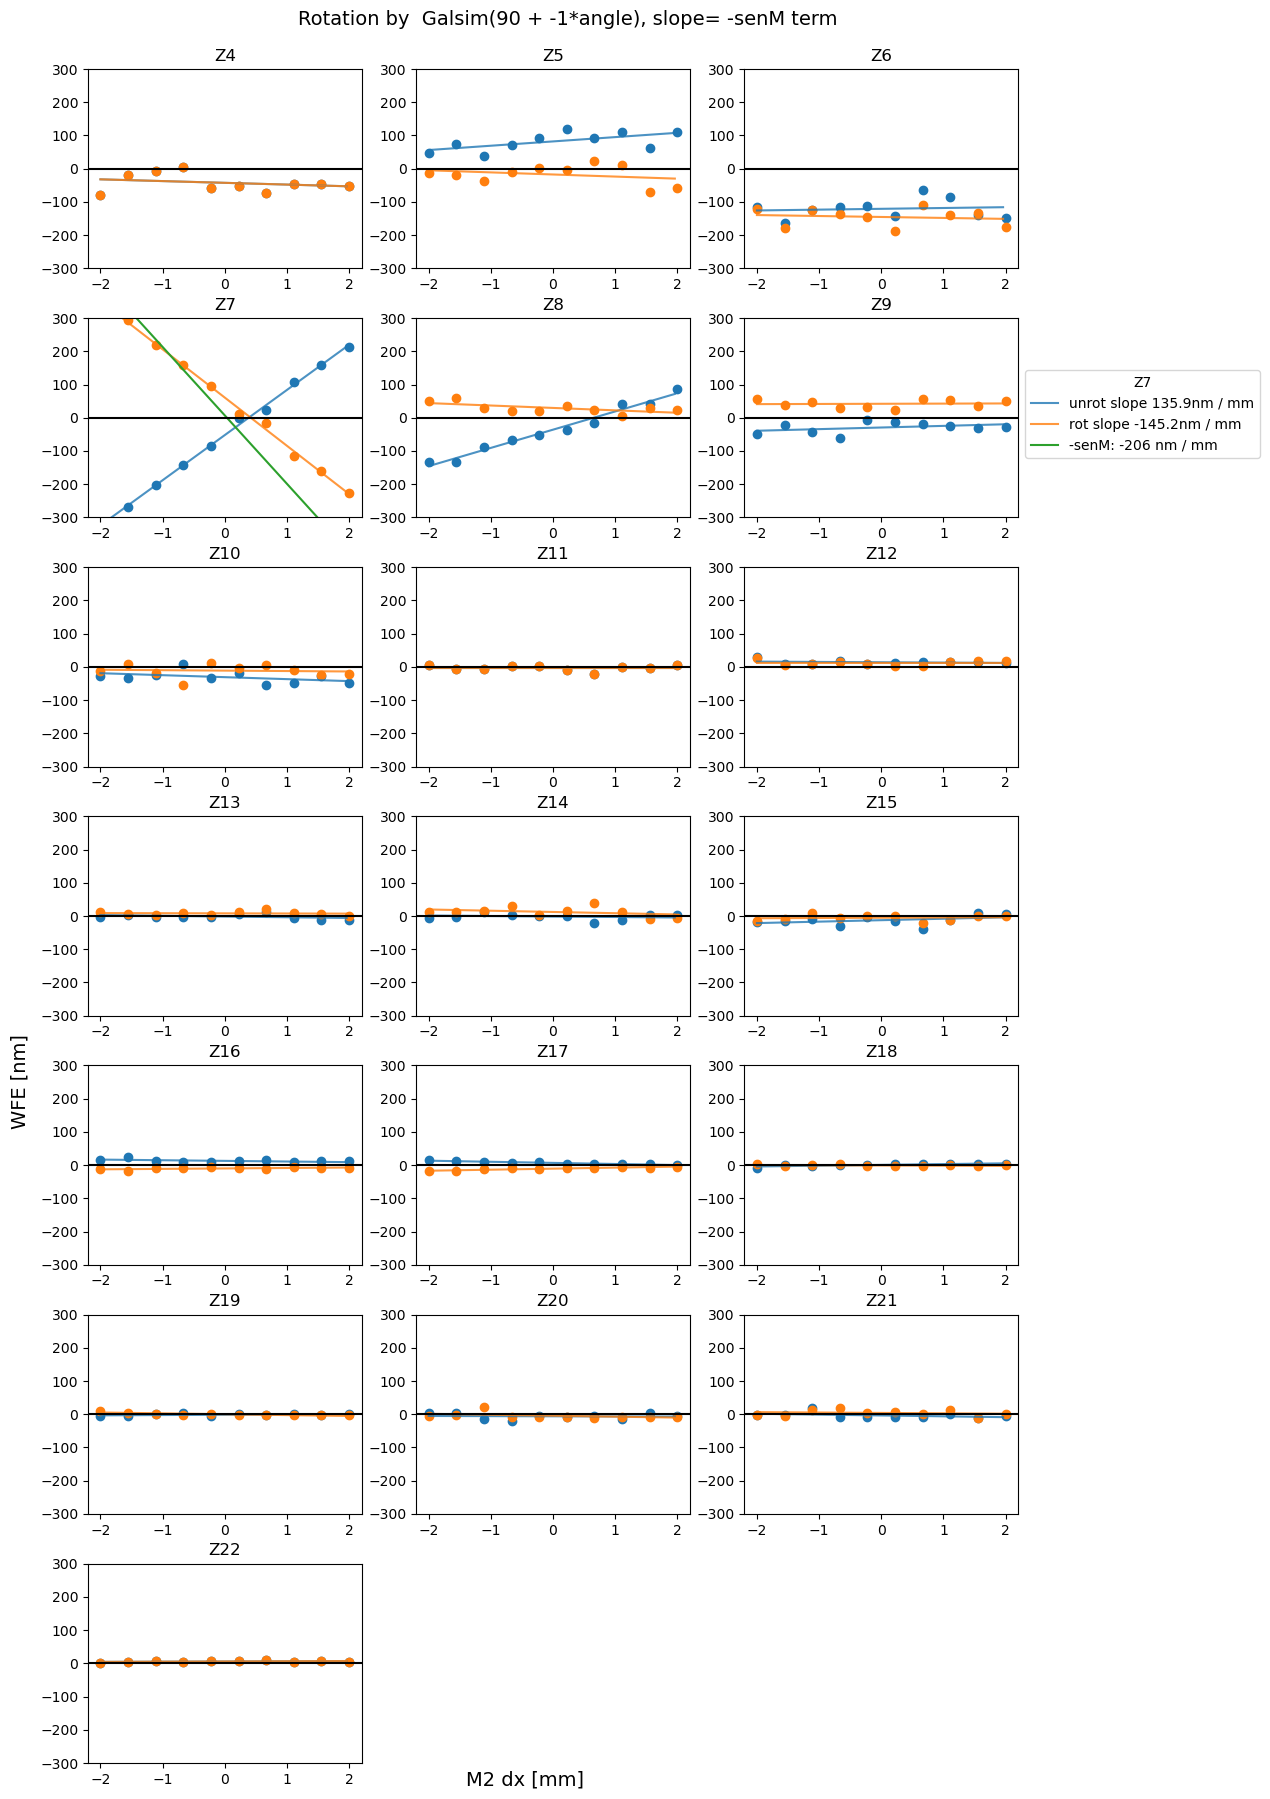

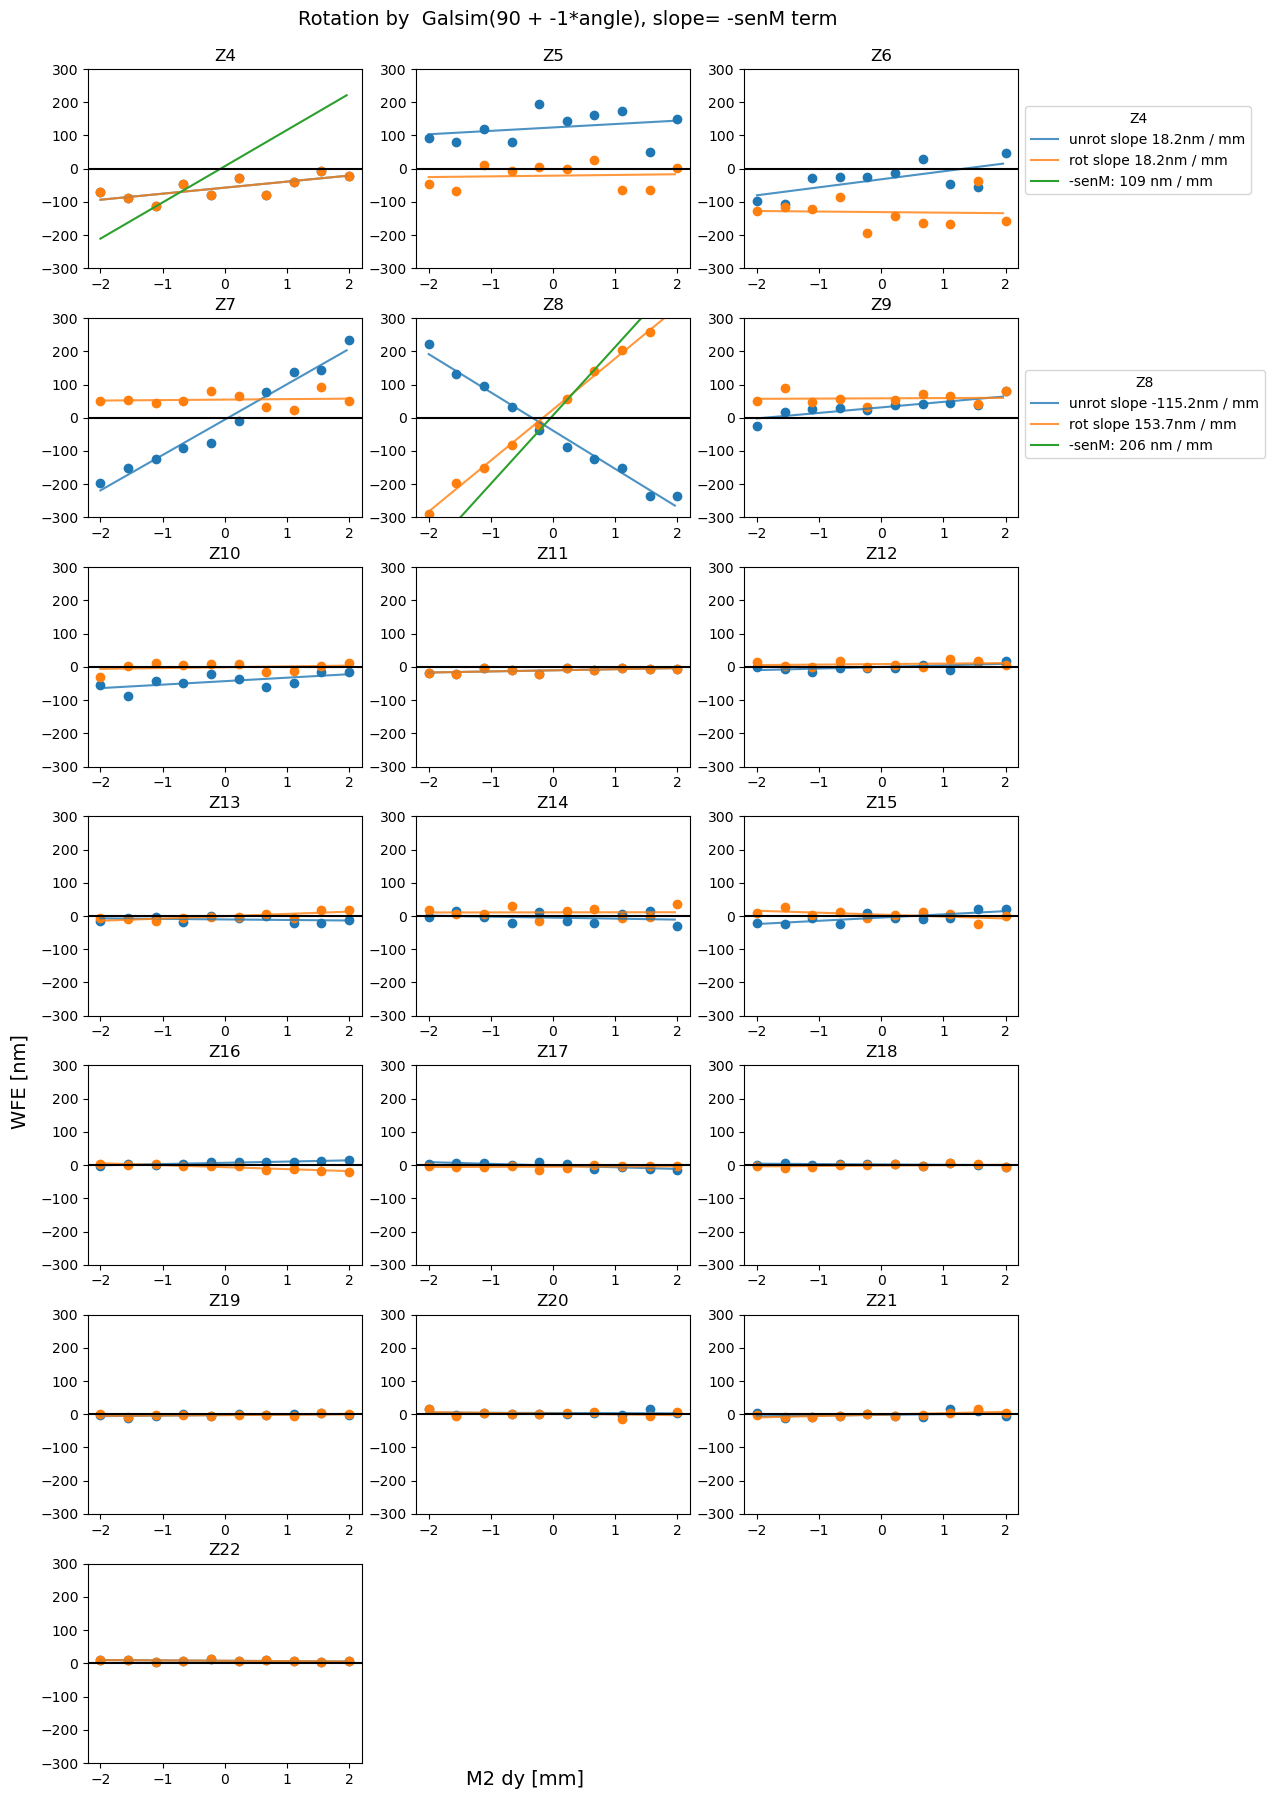

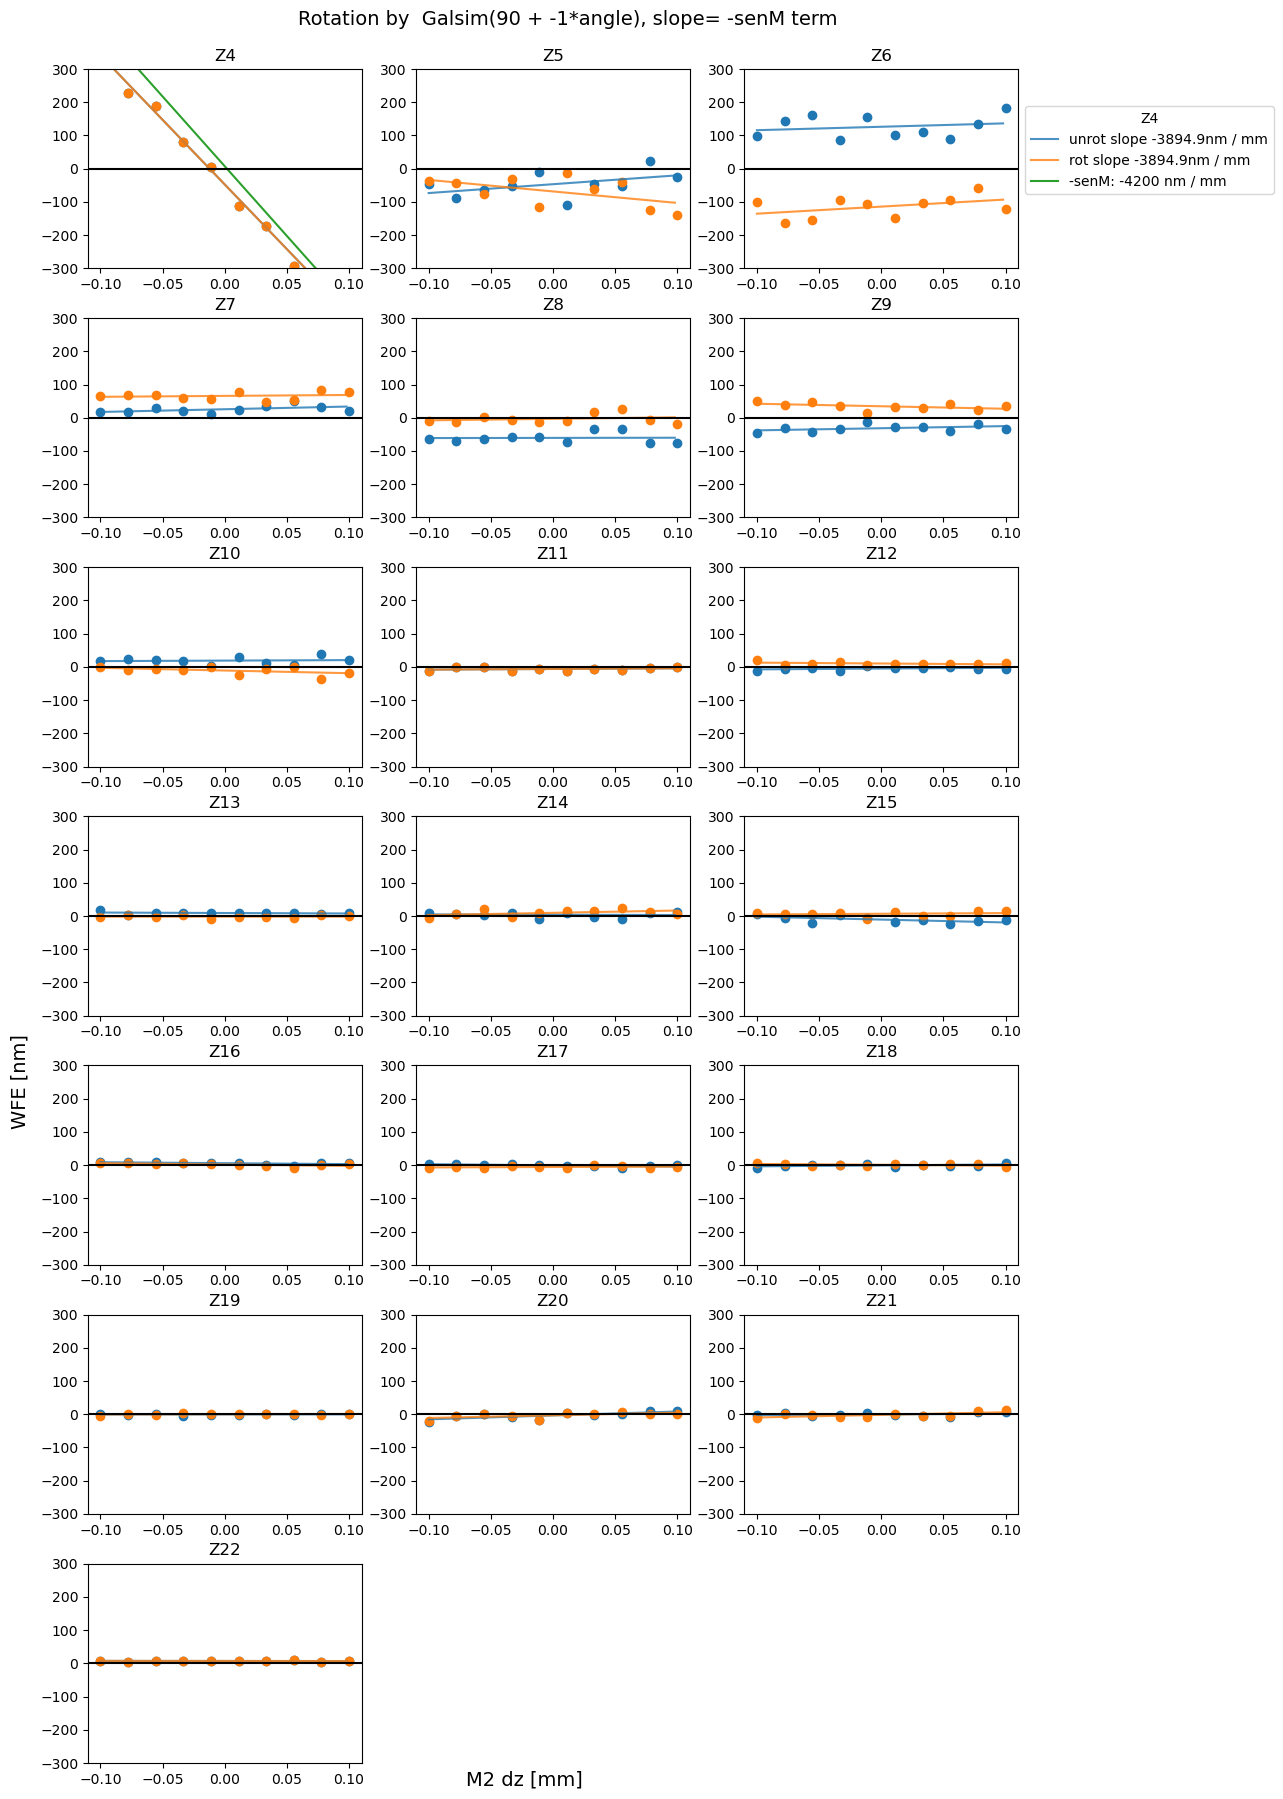

In [25]:
def plot_sens_rot(axis = 'x', verbose=True, add_angle=0, mult_angle = 1, pre='-'):
    if axis == 'x':
        dxs = np.linspace(-2, 2, 10)  
        intra_seq_nums = np.arange(71, 90, 2)
    
    elif axis == 'y':
        dxs = np.linspace(-2, 2, 10) # this is dy 
        intra_seq_nums = np.arange(91, 110, 2)
        
    elif axis == 'z':  
        dxs = np.linspace(-0.1, 0.1, 10) # this is dz 
        intra_seq_nums = np.arange(172, 191, 2)
    
    # read in the appropriate zernikes 
    zernikes = []
    for seq_num in intra_seq_nums:
        zernikes.append(
            butler.get(
                "zernikeEstimateAvg", 
                dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
            )
        )
    zernikes = np.array(zernikes)
    
    # first, pad with 4 zeros so that array[N]  corresponds to ZkN
    zk1_22_list = []
    for zk4_22 in zernikes:
        zk1_22 = np.pad(zk4_22,[4,0])
        zk1_22_list.append(zk1_22)
    zk1_22_arr = np.array(zk1_22_list)

    # now derotate using the  EFD angle = el-rot 
    zk1_22_rot_list = []
    for pair in range(len(intra_seq_nums)):

        zk1_22_unrot = zk1_22_arr[pair]

        seq_num = intra_seq_nums[pair]
        intra_name = 'AT_O_20230310_'+   str(seq_num).zfill(6)

        # derotate by applying matrix multiplication
        angle =  d[d['intra'] == intra_name]['angle'].value[0]
        
        # derotate using angle = rot-el 
        #                      = Nasmyth2CalculatedAngle- elevationCalculatedAngkle
        zk1_22rot = np.matmul(zk1_22_unrot, zernikeRotMatrix(22, np.deg2rad(add_angle+mult_angle*angle)))
        zk1_22_rot_list.append(zk1_22rot)

    zk1_22_rot_arr = np.array(zk1_22_rot_list)
    
    # plot the derotated and the rotated Zks 
    fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(12,22))
    axes = axes.ravel()
    xdata = dxs
    
    
    # unrotated
    if verbose: print('\n Unrotated ')
    for j in range(4, 23):  
        ydata = 1000*zk1_22_arr[:,j] # use nm 
        axes[j-4].scatter(dxs, ydata,)# label='unrot')
        
        # fit straight line 
        x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
        popt,pcov = curve_fit(line, xdata, ydata)
        if verbose:
            print(f'Z{j} as func of dx displacement fit intercept and slope ',popt)
        axes[j-4].plot(x,line(x, *popt),
         label=f'unrot slope {np.round(popt[1],1)}nm / mm', alpha=0.8)

        if verbose: print('1/slope=', 1/popt[1])
        
        axes[j-4].set_title(f"Z{j}")
    
    # rotated
    if verbose:
        print('\n Rotated ')
    for j in range(4, 23):  
        ydata = 1000*zk1_22_rot_arr[:,j] # use nm 
        axes[j-4].scatter(dxs, ydata,)# label='rot' )
        
        # fit straight line 
        x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
        popt,pcov = curve_fit(line, xdata, ydata)
        if verbose:
            print(f'Z{j} as func of dx displacement fit intercept and slope ',popt)
        axes[j-4].plot(x,line(x, *popt),
         label=f'rot slope {np.round(popt[1],1)}nm / mm', alpha=0.8)

        if verbose: print('1/slope=', 1/popt[1])
        
    # Plot slopes based on 
    #     self.matrix_sensitivity = [
    #             [1.0 / 206.0, 0.0, 0.0],
    #             [0.0, -1.0 / 206.0, -(109.0 / 206.0) / 4200],
    #             [0.0, 0.0, 1.0 / 4200.0],
    #         ]
   
    loc_string = 'lower left'
    
    # multiplication factor of the original sensitivity matrix terms ... 
    mult = int(pre+'1') 
    
    # we're plottting   zk7, zk8  ,zk4 
    zk0 = 4 # starting from Zk4.... 
    if axis == 'x':
        # dx slopes 
        # Z7 as a function of dx : Cx 
        ax_idx = 7-zk0 # zk7
        popt = [+7.20791437, mult*206]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(title='Z7', loc=loc_string, 
                           bbox_to_anchor=(0.9, 0.7),
          bbox_transform=fig.transFigure)
    
    
    elif axis == 'y':
        # dy slopes 
        # defocus as function of dy : Czy  
        ax_idx = 4-zk0
        
        popt = [+7.20791437, mult*(-109)]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(title='Z4', loc=loc_string,
                            bbox_to_anchor=(0.9, 0.82),
                            bbox_transform=fig.transFigure)

        # Z8 (comaY) as function of dy : Cy 
        ax_idx = 8-zk0
        popt = [+7.20791437, mult*(-206)]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(title='Z8', loc=loc_string,
                            bbox_to_anchor=(0.9, 0.7),
                            bbox_transform=fig.transFigure)
        
    elif axis == 'z':
        # dz slopes
        # defocus as function of dz : Dz
        ax_idx = 4-zk0
        popt = [+7.20791437, mult*4200]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(title='Z4', loc=loc_string, 
                            bbox_to_anchor=(0.9, 0.82),
                            bbox_transform=fig.transFigure)

    for ax in axes[:-2]:
        ax.set_ylim(-300, 300)
        ax.axhline(0, c='k')
        
    # add just one set of labels     
    fig.text(0.44, 0.1,  f"M2 d{axis} [mm]", fontsize=14)
    fig.text(0.06 ,0.4,"WFE [nm]", rotation='vertical',fontsize=14 )
    axes[-2].axis('off')
    axes[-1].axis('off')
    fig.text(0.3,0.9, 
             f'Rotation by  Galsim({add_angle} + {mult_angle}*angle), slope= {pre}senM term', 
             fontsize=14)
    fig.subplots_adjust(hspace=0.25)
    plt.tight_layout()
    plt.show()
    
    
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

for axis in 'xyz':
    plot_sens_rot(axis=axis, add_angle=90, mult_angle = -1, verbose=False)

# Summary

We obtained an estimate of the sensitivity matrix using the 2023-03-10 auxiliary telescope data. The resulting wavefront estimates (coefficients of Noll Zernike polynomials) from `ts_wep` were derotated using the information about the rotator and elevation angle. As a sanity check, we ensured that the rotationally-invariant total moments of each optical aberration (total coma, total trefoil) were identical between the original and derotated datasets. Plotting the derotated Zernike coefficients as a function of hexapod displacement `dx`, `dy`, `dz`,  we obtained the sensitivity matrix that describes the amount of `mm` of hexapod motion needed to correct a value  in `nm` of given Zernike coefficient. Currently WEP estimates annular Noll Zernikes 4-22, yet the sensitivity matrix only includes Z4 (defocus), Z7 (coma-x) and Z8 (coma-y). Future improvements to this work could entail inclusion of more terms of Zernikes polynomial in the sensitivity matrix, as well as an estimate of uncertainty in the estimate of each Zernike mode.   